In [1]:
# Celda 1

import pandas as pd                   # Importa la librería pandas para la manipulación de estructuras de datos (DataFrames)
import numpy as np                    # Importa numpy para operaciones numéricas y manejo de arrays
import matplotlib.pyplot as plt       # Importa matplotlib para la creación de gráficos
import yfinance as yf                 # Importa yfinance para descargar datos financieros desde Yahoo Finance
from statsmodels.tsa.seasonal import seasonal_decompose  # Importa la función para descomponer series de tiempo
from statsmodels.tsa.arima.model import ARIMA            # Importa el modelo ARIMA para análisis y predicción de series
import seaborn as sns  # Seaborn maneja los estilos de Matplotlib
sns.set_style("darkgrid")  # Aplica un estilo de cuadrícula oscura



In [2]:
# Celda 2

# Definimos el símbolo y el rango de fechas para descargar los datos
ticker_symbol = 'AAPL'                # Símbolo de la acción de Apple
start_date = '2020-01-01'             # Fecha de inicio para la descarga de datos
end_date = '2022-12-31'               # Fecha de finalización para la descarga de datos

# Descargamos los datos históricos de AAPL y los almacenamos en un DataFrame
df = yf.download(ticker_symbol, start=start_date, end=end_date)  # Función que descarga los datos de Yahoo Finance

# Mostramos las primeras 5 filas del DataFrame para verificar su contenido
df.head()                             # Imprime las primeras 5 filas del DataFrame


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.716072,72.776598,71.466812,71.721019,135480400
2020-01-03,72.009109,72.771737,71.783954,71.941321,146322800
2020-01-06,72.582916,72.621654,70.876083,71.127873,118387200
2020-01-07,72.241547,72.849224,72.021231,72.592594,108872000
2020-01-08,73.403641,73.706271,71.943751,71.943751,132079200


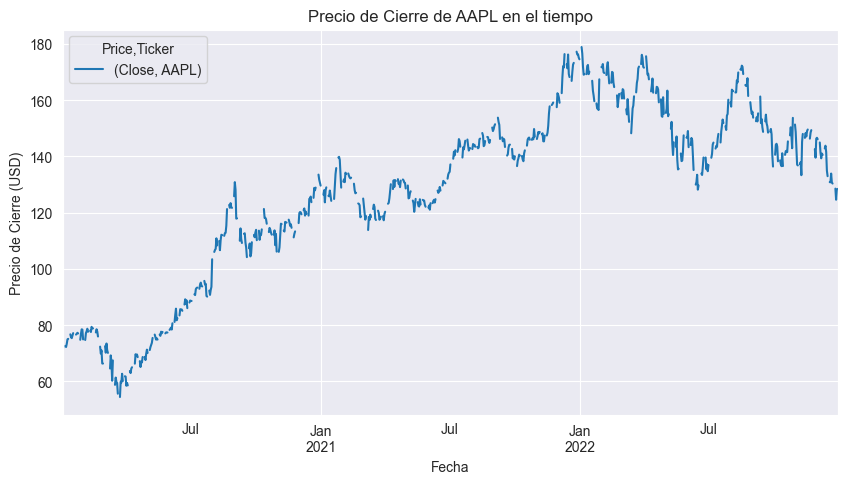

In [3]:
# Celda 3

# Verificamos que el DataFrame `df` ha sido cargado correctamente
if 'df' not in locals():
    raise ValueError("El DataFrame 'df' no está definido. Asegúrate de ejecutar la Celda 2 antes de esta.")

# Seleccionamos la columna 'Close' para nuestro análisis de series de tiempo
df_ts = df[['Close']].copy()  # Copia solo la columna 'Close'

# Convertimos el índice a formato datetime (si no lo está ya)
df_ts.index = pd.to_datetime(df_ts.index)

# Asignamos una frecuencia explícita de datos diarios ('D')
df_ts = df_ts.asfreq('D')

# Visualizamos la evolución de la serie en el tiempo
df_ts.plot(figsize=(10, 5))
plt.title('Precio de Cierre de AAPL en el tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.show()


C:\Users\gonza\AppData\Local\Temp\ipykernel_3276\171237176.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ts.fillna(method='ffill', inplace=True)  # Rellena valores faltantes con el último valor conocido


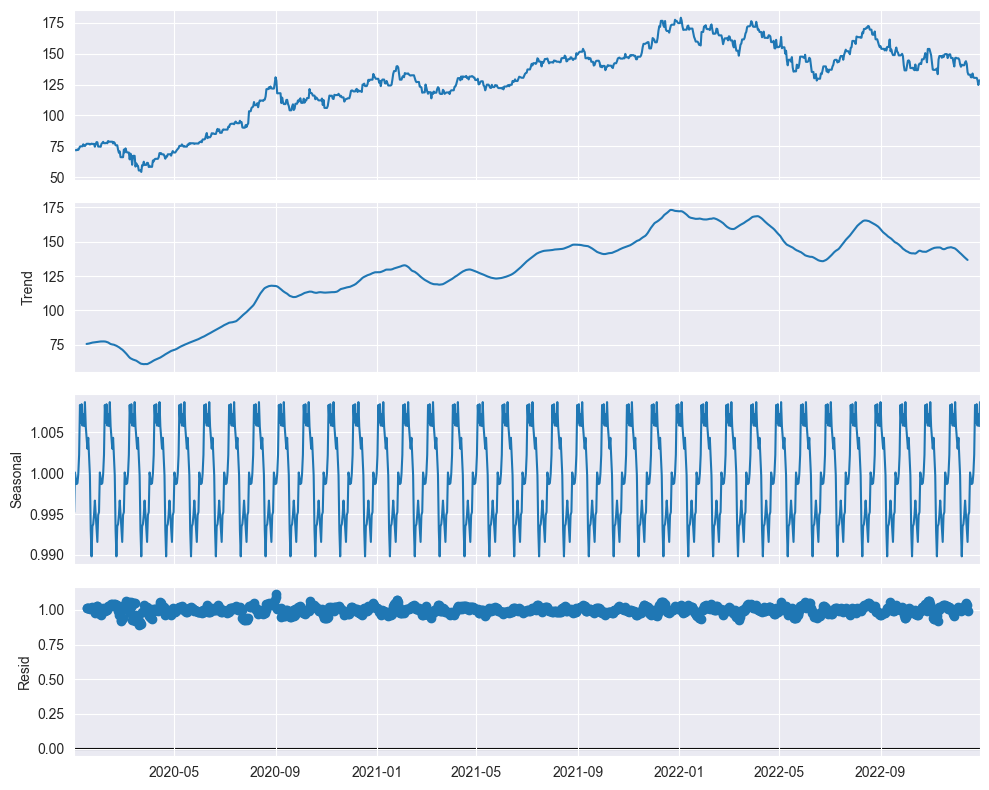

In [4]:
# Celda 4

# Antes de la descomposición, rellenamos los valores NaN para evitar errores
df_ts.fillna(method='ffill', inplace=True)  # Rellena valores faltantes con el último valor conocido

# Descomponemos la serie para observar tendencia, estacionalidad y residuo
# Se usa el modelo 'multiplicative' y un periodo de 30 días (ajustable según el dataset)
result = seasonal_decompose(df_ts['Close'], model='multiplicative', period=30)

# Graficamos los componentes
fig = result.plot()
fig.set_size_inches(10, 8)  # Ajustamos el tamaño del gráfico
plt.tight_layout()  # Ajustamos la disposición para evitar solapamientos
plt.show()


In [5]:
# Celda 5

# ARIMA requiere una serie estacionaria o casi estacionaria.
# Normalmente, podríamos tomar la diferencia de la serie para estabilizar la media.
# Sin embargo, primero haremos un split (entrenamiento/prueba) para evaluar el rendimiento del modelo.

# Definimos un corte (por ejemplo, en el 80% de los datos)
train_size = int(len(df_ts) * 0.8)  # 80% de los datos para entrenamiento
train_data = df_ts.iloc[:train_size].copy()  # Subconjunto de entrenamiento
test_data = df_ts.iloc[train_size:].copy()   # Subconjunto de prueba

print("Tamaño datos de entrenamiento:", len(train_data))
print("Tamaño datos de prueba:", len(test_data))


Tamaño datos de entrenamiento: 875
Tamaño datos de prueba: 219


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                  875
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1906.002
Date:                Sat, 15 Feb 2025   AIC                           3818.004
Time:                        01:13:39   BIC                           3832.324
Sample:                    01-02-2020   HQIC                          3823.482
                         - 05-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2350      0.310      0.757      0.449      -0.373       0.843
ma.L1         -0.3214      0.307     -1.046      0.296      -0.924       0.281
sigma2         4.5891      0.135     34.052      0.0

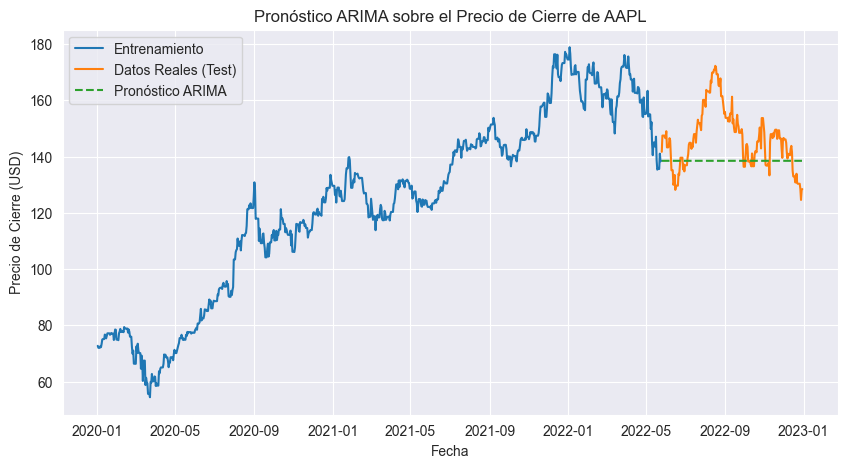

In [6]:
# Celda 6 (modificada)

# Definir los parámetros del modelo ARIMA (p, d, q)
p, d, q = 1, 1, 1  

# Creamos el modelo asegurándonos de que el índice tiene una frecuencia definida
model = ARIMA(train_data['Close'], order=(p, d, q), freq='D')  # Se agrega freq='D' para frecuencia diaria

# Ajustamos el modelo a los datos de entrenamiento
model_fit = model.fit()

# Imprimimos un resumen del modelo entrenado
print(model_fit.summary())

# Realizamos el pronóstico
forecast_steps = len(test_data)  
forecast = model_fit.forecast(steps=forecast_steps)

# Creamos un DataFrame para comparar el pronóstico con los valores reales
forecast_df = test_data.copy()
forecast_df['Predicted_ARIMA'] = forecast.values

# Graficamos los datos reales y la predicción
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data['Close'], label='Entrenamiento')
plt.plot(test_data.index, test_data['Close'], label='Datos Reales (Test)')
plt.plot(forecast_df.index, forecast_df['Predicted_ARIMA'], label='Pronóstico ARIMA', linestyle='--')
plt.title('Pronóstico ARIMA sobre el Precio de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.show()


In [7]:
# Celda 7

from sklearn.metrics import mean_squared_error, mean_absolute_error  # Importa funciones para calcular métricas de error

# Calcula el Error Cuadrático Medio (MSE) entre los datos reales y el pronóstico
mse = mean_squared_error(test_data['Close'], forecast_df['Predicted_ARIMA'])  # Calcula el MSE

# Calcula el Error Absoluto Medio (MAE) entre los datos reales y el pronóstico
mae = mean_absolute_error(test_data['Close'], forecast_df['Predicted_ARIMA'])  # Calcula el MAE

# Calcula la Raíz del Error Cuadrático Medio (RMSE) a partir del MSE
rmse = np.sqrt(mse)                 # Calcula el RMSE

# Imprime las métricas de error para evaluar el desempeño del modelo
print("Métricas de evaluación:")
print(f"MSE : {mse:.4f}")            # Muestra el MSE con 4 decimales
print(f"RMSE: {rmse:.4f}")           # Muestra el RMSE con 4 decimales
print(f"MAE : {mae:.4f}")            # Muestra el MAE con 4 decimales

# Comentarios:
# - Un RMSE bajo indica un buen ajuste del modelo.
# - Para mejorar el modelo, se puede optimizar los parámetros (p, d, q) utilizando criterios como AIC o BIC.
# - También es posible explorar otros modelos de series de tiempo, como SARIMA o Prophet.


Métricas de evaluación:
MSE : 173.4148
RMSE: 13.1687
MAE : 10.3152


# 📊 Proyecto de Análisis de Series de Tiempo

## 🔍 **Descripción del Proyecto**
Este proyecto tiene como objetivo analizar una serie de tiempo generada artificialmente con componentes de **tendencia**, **estacionalidad** y **ruido aleatorio**, para aplicar técnicas de descomposición y predicción utilizando el modelo **ARIMA**.

El análisis se divide en varias etapas clave:

1. **Exploración de los Datos** 📊  
   - Cargamos la serie de tiempo (`simulated_time_series.csv`), generada con datos de 5 años diarios.
   - Visualizamos su evolución en el tiempo para detectar patrones generales.

2. **Descomposición de la Serie de Tiempo** 🔍  
   - Separamos la serie en **tendencia**, **estacionalidad** y **residuo** utilizando `seasonal_decompose`.
   - Observamos cómo la estacionalidad afecta los valores y qué tanto ruido tiene la serie.

3. **Entrenamiento del Modelo ARIMA** 🤖  
   - Separamos los datos en conjunto de **entrenamiento (80%)** y **prueba (20%)**.
   - Ajustamos un **modelo ARIMA(1,1,1)** para capturar patrones en la serie.
   - Generamos pronósticos y comparamos con los valores reales de prueba.

4. **Evaluación del Modelo** 📉  
   - Calculamos métricas como **MSE, RMSE y MAE** para medir el error del modelo.
   - Visualizamos los valores reales frente a los valores predichos para evaluar el desempeño.

---

## 📌 **Conclusiones del Análisis**

✅ **Tendencia y Estacionalidad:**  
La serie de tiempo muestra una clara **tendencia ascendente**, indicando un crecimiento progresivo en el tiempo. También se observa una **estacionalidad anual** con picos y caídas en períodos específicos.

✅ **Descomposición Útil:**  
La descomposición de la serie permitió identificar los distintos componentes, lo que ayuda a entender mejor la evolución de los datos y a elegir modelos más precisos.

✅ **Modelo ARIMA como Herramienta de Predicción:**  
El modelo **ARIMA(1,1,1)** logra capturar parte de la tendencia de la serie, aunque puede mejorar con ajustes en los parámetros `(p, d, q)`. En el futuro, podríamos optimizarlo usando **AIC y BIC** o probar modelos más avanzados como **SARIMA**.

✅ **Evaluación del Desempeño:**  
Las métricas de error obtenidas indican que el modelo tiene un desempeño aceptable, pero aún presenta diferencias con los valores reales. Esto sugiere que pueden explorarse otros enfoques para mejorar la precisión.

✅ **Posibles Mejoras:**  
- Probar **SARIMA** para capturar mejor la estacionalidad.  
- Aplicar **Prophet** como modelo alternativo.  
- Ajustar los parámetros del modelo ARIMA usando técnicas de selección óptima.  
- Probar con datos reales para un análisis más aplicado.  

---

## 🎯 **Reflexión Final**

Este proyecto demuestra cómo el análisis de series de tiempo puede ayudarnos a comprender patrones ocultos en los datos y hacer predicciones útiles para la toma de decisiones. La combinación de técnicas de **visualización, modelado y evaluación** proporciona una base sólida para futuros proyectos de análisis predictivo. 🚀

